In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
# Sentiment Analysis: Logistic Regression vs. Naive Bayes

# Step 00: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from sklearn.utils import shuffle


In [3]:
# Step 01: Load Dataset - CORRECTED PATH
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df = shuffle(df, random_state=42)


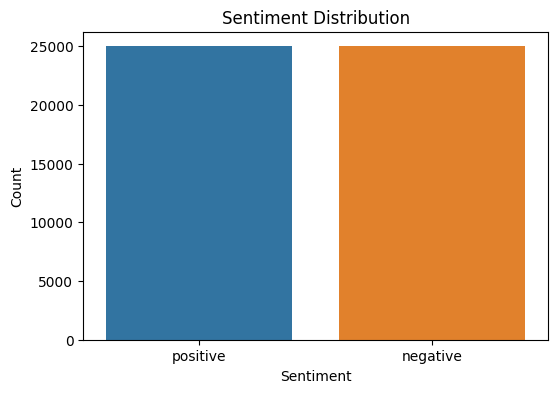

In [4]:
# Step 02: Visualization - Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [5]:
# Step 03: Preprocessing
def clean_text(text):
    text = re.sub(r'<br />', ' ', str(text))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['review'] = df['review'].apply(clean_text)
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0)


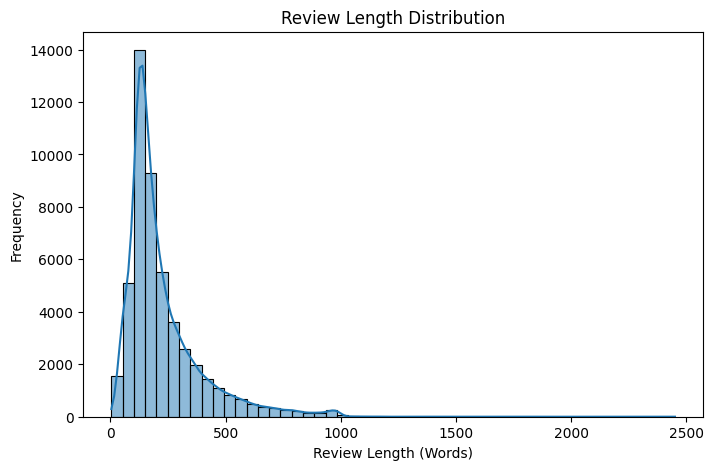

In [6]:
# Step 04: Feature Engineering
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['review'].apply(lambda x: np.mean([len(word) for word in x.split()]))

plt.figure(figsize=(8,5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.show()


In [7]:
# Step 05: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)


In [8]:
# Step 06: Text Vectorization
vectorizer = CountVectorizer(stop_words='english')
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [9]:
# Step 07: Train Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)


In [10]:
# Step 08: Train Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)


In [11]:
# Step 09: Evaluate Models
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{name} Evaluation")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(classification_report(y_true, y_pred))

    return acc, prec, rec, f1



Logistic Regression Evaluation
Accuracy: 0.90
Precision: 0.89
Recall: 0.91
F1 Score: 0.90
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4951
           1       0.89      0.91      0.90      5049

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



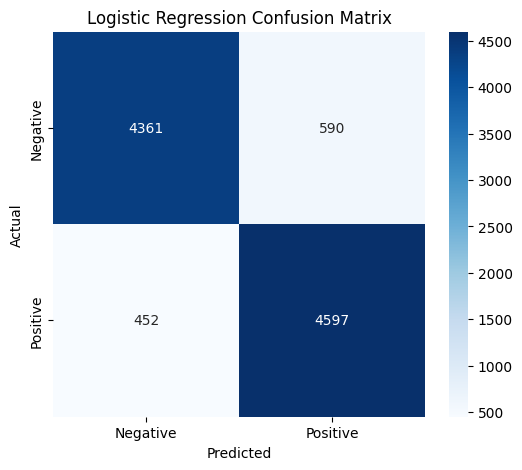

In [12]:
acc_lr, prec_lr, rec_lr, f1_lr = evaluate_model(
    "Logistic Regression", y_test, y_pred_lr
)

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()



Naive Bayes Evaluation
Accuracy: 0.86
Precision: 0.88
Recall: 0.85
F1 Score: 0.86
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4951
           1       0.88      0.85      0.86      5049

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



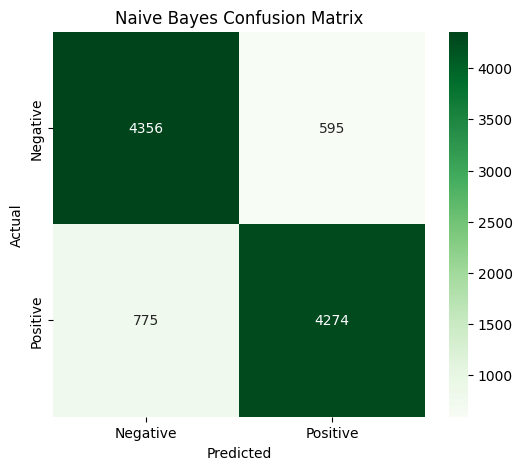

In [13]:
acc_nb, prec_nb, rec_nb, f1_nb = evaluate_model(
    "Naive Bayes", y_test, y_pred_nb
)

conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()


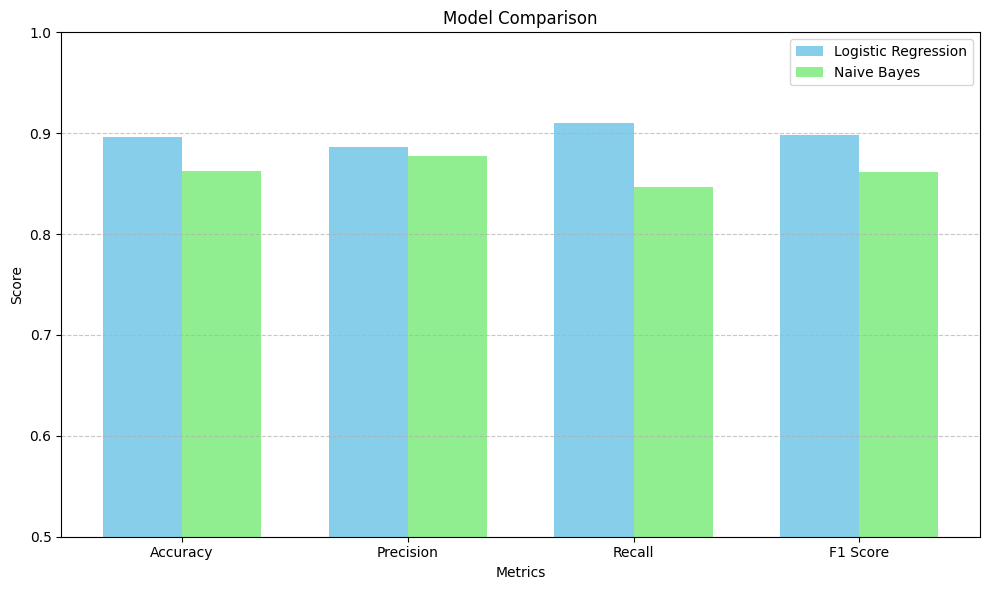

In [14]:
# Step 10: Model Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
lr_scores = [acc_lr, prec_lr, rec_lr, f1_lr]
nb_scores = [acc_nb, prec_nb, rec_nb, f1_nb]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, lr_scores, width, label='Logistic Regression', color='skyblue')
plt.bar(x + width/2, nb_scores, width, label='Naive Bayes', color='lightgreen')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x, metrics)
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [15]:
# Step 11: Save Models and Vectorizers
import joblib

joblib.dump(model_lr, "logreg_model.pkl")
joblib.dump(model_nb, "naive_bayes_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(tfidf_transformer, "tfidf.pkl")


['tfidf.pkl']

In [16]:
print("LR:", 'model_lr' in globals())
print("NB:", 'model_nb' in globals())
print("Vectorizer:", 'vectorizer' in globals())
print("TFIDF:", 'tfidf_transformer' in globals())


LR: True
NB: True
Vectorizer: True
TFIDF: True
